In [1]:
import tensorflow as tf
import numpy as np
import sklearn
import random,os,io
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint,CSVLogger
from tensorboard.plugins.hparams import api as hp

In [2]:
import pandas as pd
dep_train=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XTr.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_train=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yTr.dat",sep='\s+',names=['target'])
dep_val=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XV.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_val=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yV.dat",sep='\s+',names=["target"])
dep_test=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XT.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_test=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yT.dat",sep='\s+',names=["target"])

dep_train.shape,indep_train.shape,dep_val.shape,indep_val.shape,dep_test.shape,indep_test.shape

((42039, 16), (42039, 1), (10935, 16), (10935, 1), (10934, 16), (10934, 1))

In [3]:
class SobolevNetwork(Model):
    def __init__(self, input_dim, num_hidden1,num_hidden2,num_hidden3,num_hidden4,num_hidden5,num_hidden6,dropout,init = None):
        super(SobolevNetwork, self).__init__()
        self.input_dim = input_dim 
       

        self.W1 = tf.Variable(tf.random.normal([self.input_dim, num_hidden1],stddev=0.1))
        self.b1 = tf.Variable(tf.ones([num_hidden1]))
        self.dp1 = tf.keras.layers.Dropout(dropout)
        self.W2 = tf.Variable(tf.random.normal([num_hidden1, num_hidden2],stddev=0.1))
        self.b2 = tf.Variable(tf.ones([num_hidden2]))
        self.dp2 = tf.keras.layers.Dropout(dropout)
        self.W3 = tf.Variable(tf.random.normal([num_hidden2, num_hidden3],stddev=0.1))
        self.b3 = tf.Variable(tf.ones([num_hidden3]))
        self.dp3 = tf.keras.layers.Dropout(dropout)
        self.W4 = tf.Variable(tf.random.normal([num_hidden3, num_hidden4],stddev=0.1))
        self.b4 = tf.Variable(tf.ones([num_hidden4]))
        self.dp4 = tf.keras.layers.Dropout(dropout)
        self.W5 = tf.Variable(tf.random.normal([num_hidden4, num_hidden5],stddev=0.1))
        self.b5 = tf.Variable(tf.ones([num_hidden5]))
        self.dp5 = tf.keras.layers.Dropout(dropout)
        self.W6 = tf.Variable(tf.random.normal([num_hidden5, num_hidden6],stddev=0.1))
        self.b6 = tf.Variable(tf.ones([num_hidden6]))
        self.dp6 = tf.keras.layers.Dropout(dropout)        
        self.W7 = tf.Variable(tf.random.normal([num_hidden6, 1],stddev=0.1))
        self.b7 = tf.Variable(tf.ones([1]))
        self.w = [(self.W1, self.b1), (self.W2, self.b2), (self.W3, self.b3),(self.W4, self.b4), (self.W5, self.b5), (self.W6, self.b6),(self.W7, self.b7)]
        
    def call(self, X):
        #Input layer
        out = X
        #Hidden layers
        W,b = self.w[0]
        out = tf.nn.tanh(tf.matmul(out, W) + b)
        out = self.dp1(out)
        W,b = self.w[1]
        out = tf.nn.tanh(tf.matmul(out, W) + b)
        out = self.dp2(out)
        W,b = self.w[2]
        out = tf.nn.sigmoid(tf.matmul(out, W) + b)
        out = self.dp3(out)
        W,b = self.w[3]
        out = tf.nn.sigmoid(tf.matmul(out, W) + b)
        out = self.dp4(out)
        W,b = self.w[4]
        out = tf.nn.leaky_relu(tf.matmul(out, W) + b)
        out = self.dp5(out)
        W,b = self.w[5]
        out = tf.nn.relu(tf.matmul(out, W) + b)
        #Output layer
        W,b = self.w[-1]
        out = tf.matmul(out, W) + b
        return out


In [4]:
es_callback = EarlyStopping( monitor='val_loss',min_delta=0,patience=5, verbose=1, mode="auto", baseline=None, restore_best_weights=False)

In [5]:
def model_builder(hp):

  hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=50)
  hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=50)
  hp_layer_3 = hp.Int('layer_3', min_value=1, max_value=1000, step=50)
  hp_layer_4 = hp.Int('layer_4', min_value=1, max_value=1000, step=50)
  hp_layer_5 = hp.Int('layer_5', min_value=1, max_value=1000, step=50)
  hp_layer_6 = hp.Int('layer_6', min_value=1, max_value=1000, step=50)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_drop_out = hp.Choice('drop_out', values=[0.1, 0.2, 0.15])

  model= SobolevNetwork(input_dim=16,num_hidden1=hp_layer_1,num_hidden2=hp_layer_2,num_hidden3=hp_layer_3,num_hidden4=hp_layer_4,num_hidden5=hp_layer_5,num_hidden6=hp_layer_6,dropout=hp_drop_out)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error', metrics=["mean_squared_error"])
  
  return model

In [6]:
from keras_tuner import RandomSearch
from keras_tuner import Objective

tuner1 =  RandomSearch(hypermodel=model_builder,
                      objective="val_mean_squared_error",
                      #objective=Objective(name="val_mean_squared_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="sobelbnetwork",
                      overwrite=True
                    )

# tuner1.search(X_train_reg, Y_train_reg, batch_size=32, epochs=10, validation_data=(X_test_reg, Y_test_reg))
tuner1.search(dep_train, indep_train, batch_size=32, epochs=3, validation_data=(dep_val, indep_val))


Trial 5 Complete [00h 01m 23s]
val_mean_squared_error: 9.13090116227977e-05

Best val_mean_squared_error So Far: 9.13090116227977e-05
Total elapsed time: 00h 08m 16s
INFO:tensorflow:Oracle triggered exit


In [7]:
best_params = tuner1.get_best_hyperparameters()

best_params[0].values

{'layer_1': 251,
 'layer_2': 601,
 'layer_3': 201,
 'layer_4': 51,
 'layer_5': 951,
 'layer_6': 401,
 'learning_rate': 0.01,
 'drop_out': 0.2}

In [9]:
best_model = tuner1.get_best_models()[0]


In [11]:
history=best_model.fit(dep_train, indep_train, batch_size=32, epochs=3, validation_data=(dep_val, indep_val))

Epoch 1/3
1314/1314 [==============================] - 30s 23ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 4.3801e-04 - val_mean_squared_error: 4.3801e-04
Epoch 2/3
1314/1314 [==============================] - 30s 23ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 1.6574e-05 - val_mean_squared_error: 1.6574e-05
Epoch 3/3
1314/1314 [==============================] - 28s 21ms/step - loss: 8.3639e-04 - mean_squared_error: 8.3639e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015


In [13]:
history.history

{'loss': [0.001612399471923709, 0.001024332595989108, 0.0008363888482563198],
 'mean_squared_error': [0.001612399471923709,
  0.001024332595989108,
  0.0008363888482563198],
 'val_loss': [0.0004380123282317072,
  1.6574380424572155e-05,
  0.00148554309271276],
 'val_mean_squared_error': [0.0004380123282317072,
  1.6574380424572155e-05,
  0.00148554309271276]}

In [14]:
mean_squared_error = history.history['mean_squared_error']
val_mean_squared_error = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

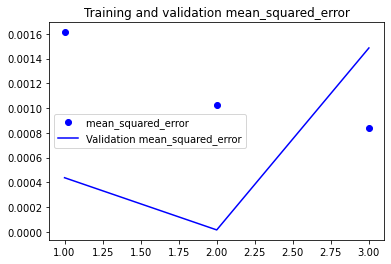

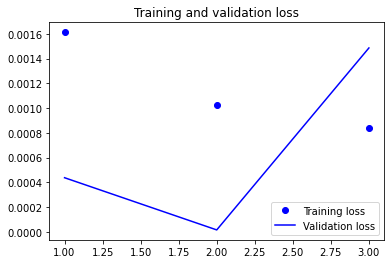

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(mean_squared_error) + 1)

plt.plot(epochs, mean_squared_error, 'bo', label='mean_squared_error ')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean_squared_error')
plt.title('Training and validation mean_squared_error')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
predict_=best_model.predict(dep_test)

342/342 [==============================] - 3s 7ms/step


In [37]:
# predict=predict_.reshape(1,0)
predict=np.concatenate(predict_)

In [38]:
temp_df=pd.DataFrame(zip(indep_test['target'],predict),columns=['test_y','predict_y'])


In [39]:
temp_df

,test_y,predict_y
0,0.016498,0.050218
1,0.014071,0.050220
2,0.016428,0.050218
3,0.012589,0.050216
4,0.013429,0.050218
...,...,...
10929,0.013651,0.050220
10930,0.015405,0.050215
10931,0.011664,0.050219
10932,0.015707,0.050219


In [40]:
temp_df=temp_df.sort_values('test_y')
ind=[index_ for index_ in range(1,len(predict_)+1)]
temp_df['index']=ind
temp_df.head()

,test_y,predict_y,index
3640,0.007435,0.050214,1
7652,0.007471,0.050214,2
2785,0.007496,0.050214,3
10489,0.007526,0.050214,4
1359,0.007535,0.050214,5


In [43]:
temp_df.describe()

,test_y,predict_y,index
count,10934.000000,10934.000000,10934.000000
mean,0.011885,0.050220,5467.500000
std,0.003620,0.000004,3156.518256
min,0.007435,0.050213,1.000000
25%,0.009836,0.050215,2734.250000
50%,0.011136,0.050218,5467.500000
75%,0.012847,0.050220,8200.750000
max,0.066101,0.050221,10934.000000


<AxesSubplot:xlabel='index'>

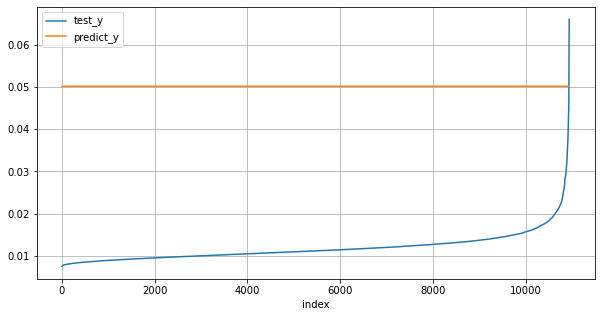

In [41]:
temp_df.plot(x='index',y=['test_y','predict_y'],figsize=(10,5),grid=True)

In [44]:
tf.keras.utils.plot_model(best_model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
loss, MSE=best_model.evaluate(dep_test, indep_test)
loss,MSE

342/342 [==============================] - 3s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015


(0.0014824592508375645, 0.0014824592508375645)

In [58]:
tf.compat.v1.enable_eager_execution()
best_model.save('temp_model',save_format = "tf")


ValueError: tf.enable_eager_execution must be called at program startup.

In [ ]:
reloaded_model = tf.keras.models.load_model('temp_model')
predictions = reloaded_model.predict(dep_test)

In [50]:
# compute SHAP values
import shap
tf.compat.v1.disable_v2_behavior()
background = X_train.iloc[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(best_model, dep_train)
shap_values = explainer.shap_values(dep_test)

Instructions for updating:
non-resource variables are not supported in the long term


TypeError: object of type 'NoneType' has no len()

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.columns)

In [ ]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.iloc[0,:], feature_names = test_data.columns.tolist())

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names = test_data.columns)